# Classification. Part 2
---
Author: Anatoliy Durkin

Updated: 17.03.2025

---
В данном ноутбуке будут рассмотрены несколько моделей классификации, новые функции для метрик и сами новые метрики, а также будет уделено внимание подбору гиперпараметров для моделей.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

В прошлом ноутбуке мы писали функцию, выводившую все необходимые нам метрики вместе. Мы импортировали несколько функций, но в этом ноутбуке используем только две: `confusion_matrix` выводит матрицу ошибок, а `classification_report` выдает остальные метрики, увидим уже на примере. Зачем нужен `fill_diagonal`, увидим в конце ноутбука.

In [2]:
def metrics(target, pred, fill=False):
    print(classification_report(target, pred))
    matrix = np.array(confusion_matrix(target, pred))
    if fill:
        np.fill_diagonal(matrix, 0)
    sns.heatmap(matrix, annot=True, fmt='.0f')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Матрица ошибок')

In [3]:
titles = pd.read_csv('titles_data.csv', sep=';')

In [4]:
titles

,titles,target
0,Родственник раскрыл настоящую фамилию Пугачёво...,1
1,Предсказания Матроны Московской на 2024-й год:...,1
2,"Пророчество схимонахини Нины об антихристе, ми...",1
3,«Думал об этом»: что Путин сказал о своем прее...,1
4,Путин поручил уведомить россиян об изменениях ...,1
...,...,...
3193,Путин поручил передать Республике Крым все акц...,0
3194,ЕК изучит просьбу Венгрии по нарушению Болгари...,0
3195,"Глава ""Россетей"" доложил Путину о достижении ц...",0
3196,"Платформа ""Мой экспорт"" научит устанавливать д...",0


Поделим выборку на обучающую и тестовую.

In [5]:
X_train, X_test, y_train, y_test = train_test_split(titles['titles'], titles['target'], test_size=0.2, random_state=42)

In [6]:
from sklearn.feature_extraction.text import CountVectorizer

In [7]:
txt = ['мама мыла раму',
      'мама чинила раму',
      'мама мыла, мама чинила']

In [8]:
vectorizer = CountVectorizer()
txt = vectorizer.fit_transform(txt)

In [9]:
# результат
txt.toarray()

array([[1, 1, 1, 0],
       [1, 0, 1, 1],
       [2, 1, 0, 1]])

In [10]:
# словарь
vectorizer.get_feature_names_out()

array(['мама', 'мыла', 'раму', 'чинила'], dtype=object)

In [11]:
vectorizer = CountVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

В библиотеке `sklearn` есть несколько моделей наивного байесса, мы возьмем полиномиальную, она хорошо работает как раз с данной векторизацией.

In [12]:
from sklearn.naive_bayes import MultinomialNB

In [13]:
model = MultinomialNB()
model.fit(X_train_vec, y_train)

MultinomialNB()

              precision    recall  f1-score   support

           0       0.89      0.90      0.89       301
           1       0.91      0.90      0.91       339

    accuracy                           0.90       640
   macro avg       0.90      0.90      0.90       640
weighted avg       0.90      0.90      0.90       640



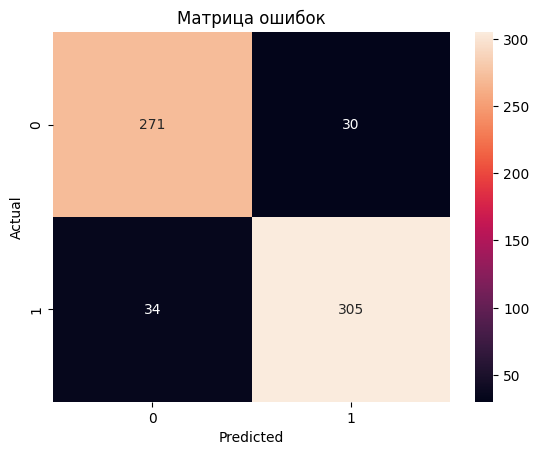

In [14]:
y_pred = model.predict(X_test_vec)
metrics(y_test, y_pred)

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

Как выглядит таблица и словарь? Напишите код, чтобы посмотреть.

In [16]:
# Корпус текстов можете заменить по желанию
txt = ['мама мыла раму',
      'мама чинила раму',
      'мама мыла, мама чинила'] 

In [17]:
# Ваш код
...

А теперь можно обучить модель с использованием данного векторизатора.

In [18]:
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

              precision    recall  f1-score   support

           0       0.90      0.90      0.90       301
           1       0.91      0.91      0.91       339

    accuracy                           0.90       640
   macro avg       0.90      0.90      0.90       640
weighted avg       0.90      0.90      0.90       640



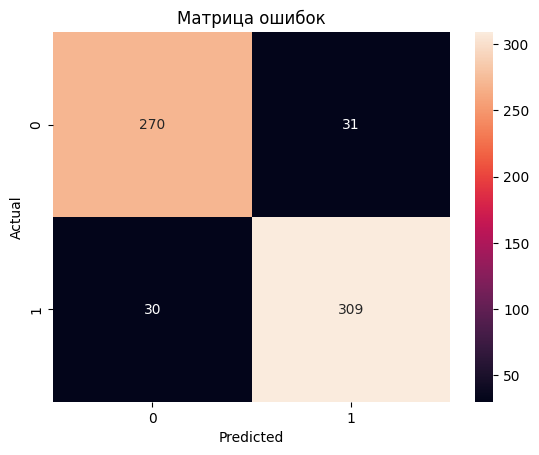

In [19]:
model = MultinomialNB()
model.fit(X_train_tfidf, y_train)
y_pred = model.predict(X_test_tfidf)
metrics(y_test, y_pred)

In [20]:
from pymystem3 import Mystem
import re
import nltk
from nltk.corpus import stopwords

Мы создадим лемматизатор, а также загрузим список стоп-слов. Это такие слова, которые обычно не несут никакой смысловой нагрузки (союзы, предлоги, etc.).

In [21]:
m = Mystem()
nltk.download('stopwords')
stop_words = list(stopwords.words('russian'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Вот что получается при работе лемматизатора:

In [22]:
m.lemmatize('Интересного текста много не бывает')

['интересный', ' ', 'текст', ' ', 'много', ' ', 'не', ' ', 'бывать', '\n']

Также накинем регулярные выражения, чтоы оставить в каждом тексте только русские буквы. И лемматизируем полученные тексты.

In [23]:
train_ru = [" ".join(re.sub(r'[^а-яА-ЯёЁ]', ' ', text).split()) for text in X_train.values.astype('U')]
train_full = ' br '.join(train_ru)
train_lem = (''.join([word for word in m.lemmatize(train_full) if word != '\n'])).split(' br ')

test_ru = [" ".join(re.sub(r'[^а-яА-ЯёЁ]', ' ', text).split()) for text in X_test.values.astype('U')]
test_full = ' br '.join(test_ru)
test_lem = (''.join([word for word in m.lemmatize(test_full) if word != '\n'])).split(' br ')

In [24]:
train_lem

['шиитский вооруженный формирование обстреливать американский база в ирак',
 'погибший военкор журавлев отмечать литературный премия',
 'кто пересчитывать пенсия с ноябрь на индексация мочь рассчитывать несколько категория',
 'вылетать через окно страшный гибель жена известный блогер',
 'депутат ямпольская выражать соболезнование в связь со смерть гладков',
 'чтобы сближаться с мужчина просто задавать он этот вопрос',
 'за место в очередь для покупка билет на щелкунчик просить тысяча рубль',
 'музей восток на выставка россия представлять много сто экспонат',
 'в россия представлять отечественный мусоровоз гибрид',
 'путин поручать разрабатывать программа развитие электроэнергетика в дфо',
 'заявление захарова о мус прогреметь на весь мир',
 'ответ знать единица как часто нужно менять губка для мытье посуда',
 'в ран сделать заявление о таинственный инопланетный сигнал',
 'невероятный заявление диетолог мочь ли простой колбаса вызывать онкология',
 'умирать писательница нина садур',
 'м

А теперь к уже обработанному корпусу применим векторизатор и построим модель.

In [25]:
tfidf_vectorizer = TfidfVectorizer(stop_words=stop_words)
X_train_lem = tfidf_vectorizer.fit_transform(train_lem)
X_test_lem = tfidf_vectorizer.transform(test_lem)

              precision    recall  f1-score   support

           0       0.88      0.88      0.88       301
           1       0.90      0.89      0.89       339

    accuracy                           0.89       640
   macro avg       0.89      0.89      0.89       640
weighted avg       0.89      0.89      0.89       640



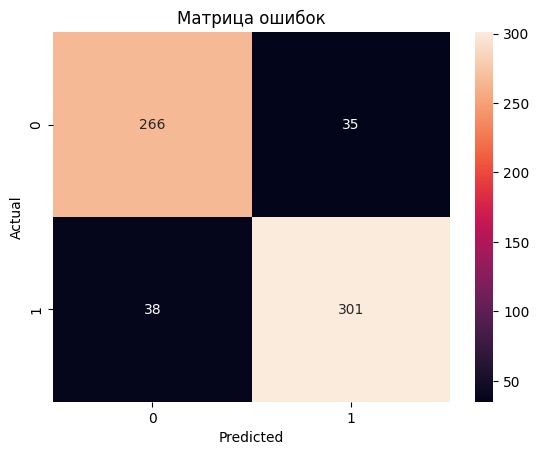

In [26]:
model = MultinomialNB()
model.fit(X_train_lem, y_train)
y_pred = model.predict(X_test_lem)
metrics(y_test, y_pred)

Результат стал даже чуть хуже, но вспомним об особенностях работы модели и попробуем это исправить. Попробуйте получить лучшие метрики.

In [27]:
# Ваш код
...

## Logistic Regression

---
Переходим к следующей модели.

Для обучения возьмем данные по диабету.

In [28]:
diabetes = pd.read_csv('diabetes_dataset.csv')

In [29]:
X_train, X_test, y_train, y_test = train_test_split(diabetes.drop(['Outcome'], axis=1), diabetes['Outcome'], test_size=0.2, random_state=42)

Для логистической регрессии обязательно нужно нормализовать данные.

In [30]:
from sklearn.preprocessing import StandardScaler

In [31]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [32]:
from sklearn.linear_model import LogisticRegression

In [33]:
clf = LogisticRegression(random_state=42).fit(X_train, y_train)

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1275
           1       1.00      0.98      0.99       633

    accuracy                           0.99      1908
   macro avg       0.99      0.99      0.99      1908
weighted avg       0.99      0.99      0.99      1908



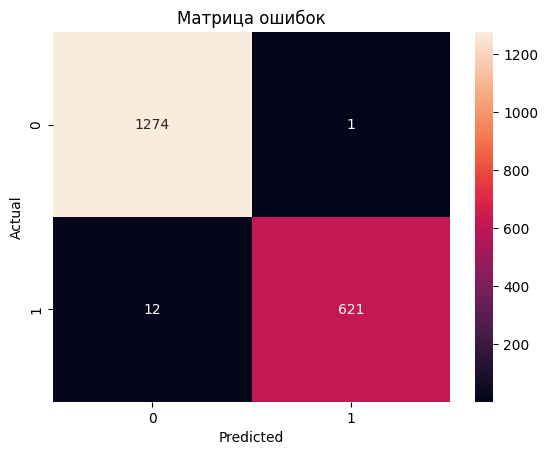

In [34]:
y_pred = clf.predict(X_test)
metrics(y_test, y_pred)

Однако, вы помните, что классы в этом датасете несббалансированны, а это не очень хорошо. Но логистическая модель может сама обучаться с поправкой на дисбаланс, главное указать это в аргументах.

In [35]:
clf = LogisticRegression(class_weight='balanced', random_state=42).fit(X_train, y_train)

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1275
           1       1.00      0.99      0.99       633

    accuracy                           1.00      1908
   macro avg       1.00      0.99      0.99      1908
weighted avg       1.00      1.00      1.00      1908



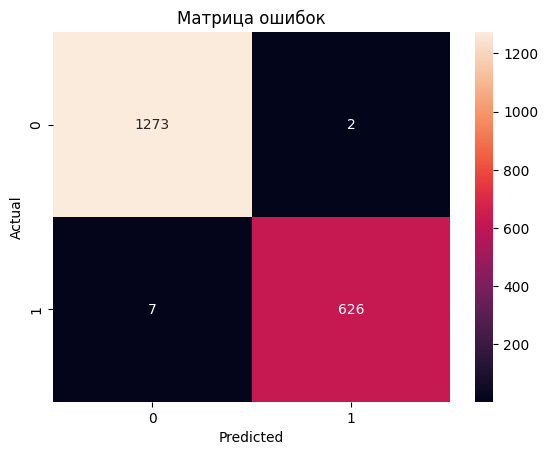

In [36]:
y_pred = clf.predict(X_test)
metrics(y_test, y_pred)

In [37]:
from sklearn.metrics import roc_curve, roc_auc_score

In [38]:
proba = clf.predict_proba(X_test)
proba_one = proba[:, 1]

In [39]:
proba

array([[8.78218188e-01, 1.21781812e-01],
       [3.10591431e-08, 9.99999969e-01],
       [9.94601126e-01, 5.39887441e-03],
       ...,
       [9.95488567e-01, 4.51143275e-03],
       [1.17832488e-06, 9.99998822e-01],
       [9.99281435e-01, 7.18565234e-04]], shape=(1908, 2))

In [40]:
proba_one

array([1.21781812e-01, 9.99999969e-01, 5.39887441e-03, ...,
       4.51143275e-03, 9.99998822e-01, 7.18565234e-04], shape=(1908,))

Нам нужны два важных значения. Вспомним матрицу ошибок

---
|           | Predicted: 0 | Predicted:1 |
|-----------|:------------:|:-----------:|
| Actual: 0 | TN           | FP          |
| Actual: 1 | FN           | TP          |

---
$TPR = \frac{TP}{TP+FN}$

$FPR = \frac{FP}{FP+TN}$

Что отражают TPR и FPR?

In [41]:
fpr, tpr, thresholds = roc_curve(y_test, proba_one)

Text(0.5, 1.0, 'ROC-кривая')

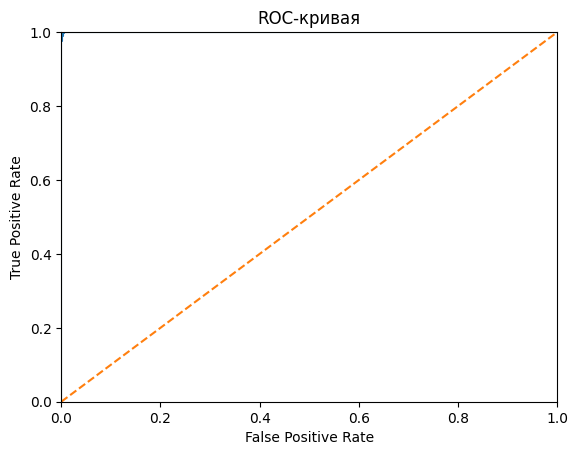

In [42]:
plt.figure()
plt.plot(fpr, tpr)

# ROC-кривая случайной модели (выглядит как прямая)
plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlim([0, 1])
plt.ylim([0, 1])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')

Для данной модели ROC-кривая почти идеальна, это замечательно. А метрика AUC-ROC - это площадь под ROC-кривой.

In [43]:
auc_roc = roc_auc_score(y_test, y_pred)
print('AUC-ROC:',auc_roc)

AUC-ROC: 0.993686460366137


In [44]:
diabetes

,Age,Pregnancies,BMI,Glucose,BloodPressure,HbA1c,LDL,HDL,Triglycerides,WaistCircumference,HipCircumference,WHR,FamilyHistory,DietType,Hypertension,MedicationUse,Outcome
0,69,5,28.39,130.1,77.0,5.4,130.4,44.0,50.0,90.5,107.9,0.84,0,0,0,1,0
1,32,1,26.49,116.5,72.0,4.5,87.4,54.2,129.9,113.3,81.4,1.39,0,0,0,0,0
2,89,13,25.34,101.0,82.0,4.9,112.5,56.8,177.6,84.7,107.2,0.79,0,0,0,1,0
3,78,13,29.91,146.0,104.0,5.7,50.7,39.1,117.0,108.9,110.0,0.99,0,0,0,1,1
4,38,8,24.56,103.2,74.0,4.7,102.5,29.1,145.9,84.1,92.8,0.91,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9533,32,3,23.00,102.3,62.0,4.1,109.3,47.8,76.7,86.8,115.0,0.75,0,0,0,0,0
9534,74,0,24.29,125.8,93.0,5.3,95.8,66.6,103.7,90.1,94.3,0.96,1,0,0,1,1
9535,75,6,26.10,107.6,75.0,5.0,168.5,62.3,149.8,84.0,114.9,0.73,0,0,0,1,0
9536,52,1,25.88,99.3,96.0,4.6,70.0,48.4,122.9,97.5,88.7,1.10,1,0,0,0,1


<Axes: title={'center': 'Корреляционная матрица'}>

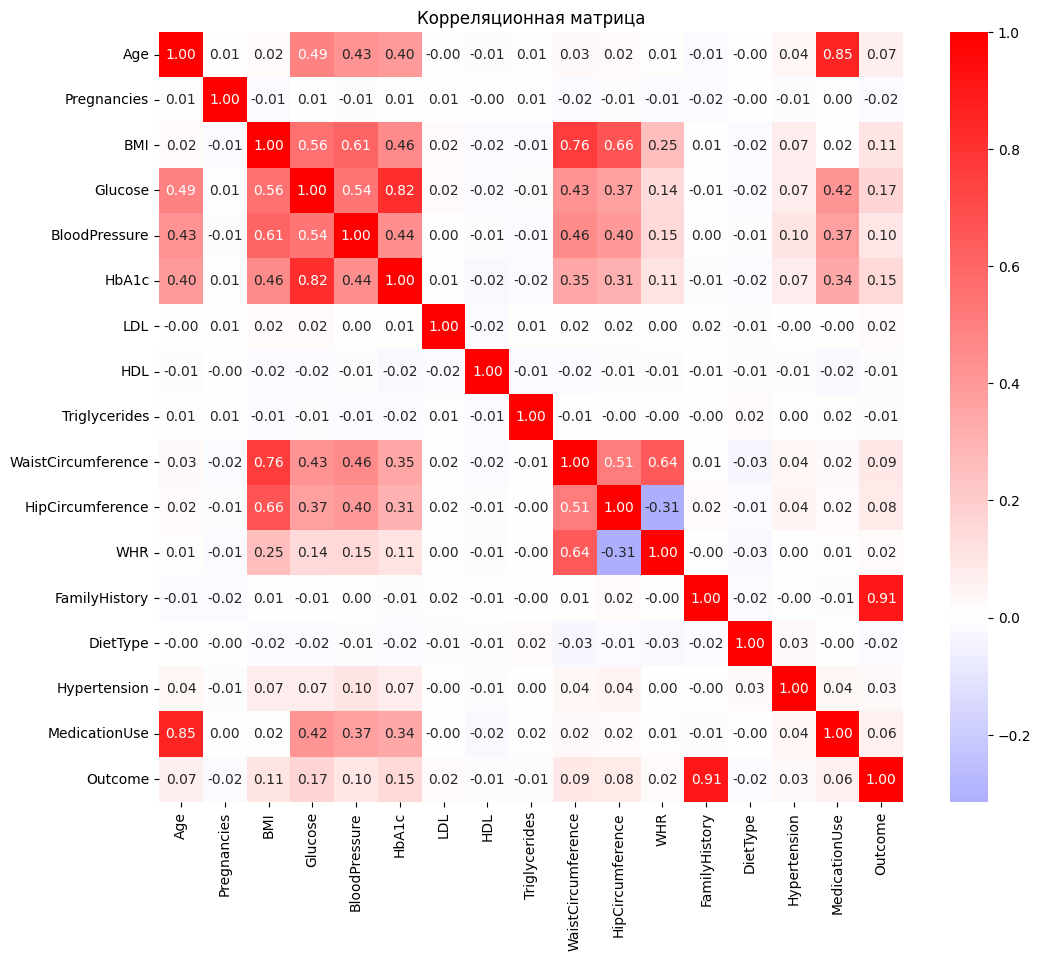

In [45]:
plt.figure(figsize=(12,10))
plt.title('Корреляционная матрица')
sns.heatmap(diabetes.corr(), cmap='bwr', center=0, annot=True, fmt='.2f')

Обучим простую модель случайного леса. Исключаю `FamilyHistory` для снижения метрик, глубину деревьев беру рандомно, число никак не подбиралось.

In [46]:
from sklearn.ensemble import RandomForestClassifier

In [47]:
X_train, X_test, y_train, y_test = train_test_split(diabetes.drop(['Outcome', 'FamilyHistory'], axis=1), diabetes['Outcome'], test_size=0.2, random_state=42)

In [48]:
rf = RandomForestClassifier(max_depth=8, random_state=42).fit(X_train, y_train)

              precision    recall  f1-score   support

           0       0.71      1.00      0.83      1275
           1       0.96      0.17      0.29       633

    accuracy                           0.72      1908
   macro avg       0.84      0.58      0.56      1908
weighted avg       0.79      0.72      0.65      1908



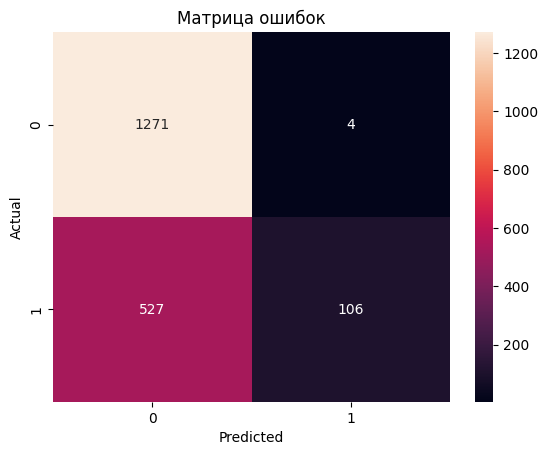

In [49]:
metrics(y_test, rf.predict(X_test))

А теперь повторим процесс, но из признаков исключим также `HbA1c`. Он сильно коррелирует с `Glucose`, а значит, они несут очень схожую информацию для модели. Посмотрим, к чему это приведет.

In [50]:
X_train, X_test, y_train, y_test = train_test_split(diabetes.drop(['Outcome', 'FamilyHistory', 'HbA1c'], axis=1), diabetes['Outcome'], test_size=0.2, random_state=42)

In [51]:
rf = RandomForestClassifier(max_depth=8, random_state=42).fit(X_train, y_train)

              precision    recall  f1-score   support

           0       0.71      1.00      0.83      1275
           1       0.97      0.17      0.29       633

    accuracy                           0.72      1908
   macro avg       0.84      0.58      0.56      1908
weighted avg       0.80      0.72      0.65      1908



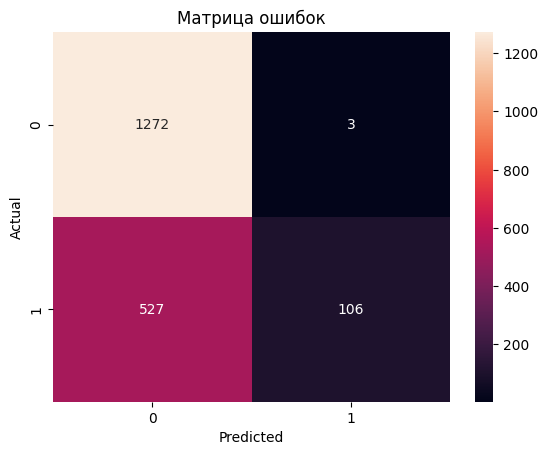

In [52]:
metrics(y_test, rf.predict(X_test))

Изменения почти отсутсвуют, но всё же есть, и в лучшую сторону. Значит такой подход к выбору признаков работает.

Есть множество способов отбора признаков, о некоторых поговорим, когда будем работать с регрессией.

А ещё можно посмотреть на важность признаков в обученной модели с помощью метода `feature_importances_`.

In [53]:
pd.Series(data=rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)

Glucose               0.510425
BMI                   0.075237
WaistCircumference    0.057818
HipCircumference      0.055166
HDL                   0.050402
Age                   0.046472
LDL                   0.044828
BloodPressure         0.044731
Triglycerides         0.043186
WHR                   0.034389
Pregnancies           0.021499
DietType              0.008048
MedicationUse         0.007577
Hypertension          0.000222
dtype: float64

Попробуйте построить ту же модель, исключив неважные признаки, изменится ли качество.

In [54]:
# Ваш код
...

Также посмотрим на ROC-кривую для такой модели (у случайного леса тоже есть такие методы).

In [55]:
fpr, tpr, thresholds = roc_curve(y_test, rf.predict_proba(X_test)[:, 1])

Text(0.5, 1.0, 'ROC-кривая')

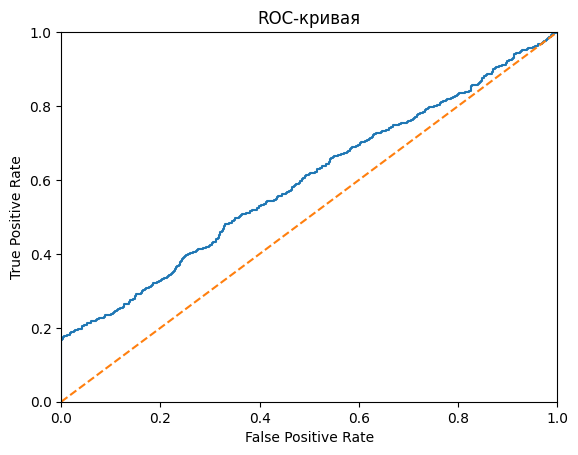

In [56]:
plt.figure()
plt.plot(fpr, tpr)

# ROC-кривая случайной модели (выглядит как прямая)
plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlim([0, 1])
plt.ylim([0, 1])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')

In [57]:
auc_roc = roc_auc_score(y_test, rf.predict(X_test))
print(auc_roc)

0.5825518074528389


In [58]:
X_train, X_test, y_train, y_test = train_test_split(diabetes.drop(['Outcome', 'FamilyHistory'], axis=1), diabetes['Outcome'], test_size=0.2, random_state=42)

In [59]:
rf = RandomForestClassifier()

In [60]:
from sklearn.model_selection import GridSearchCV

В `SridSearchCV` мы передаем нужную нам модель и перечень гиперпараметров, которые хотим варьировать, с желаемыми значениями. Также можно указать, на сколько частей бить данные при кросс-валидации, и желаемую метрику. Сколько раз будет обучаться модель при следующих параметрах?

In [61]:
parameters = {'max_depth': [5, 8], 'n_estimators': [50, 100], 'random_state': [42]}
clf = GridSearchCV(rf, parameters, cv=5, scoring='roc_auc')
clf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [5, 8], 'n_estimators': [50, 100],
                         'random_state': [42]},
             scoring='roc_auc')

А после обучения можно посмотреть на лучшую оценку, лучшую модель и просто посмотреть на все результаты обучения.

In [62]:
clf.best_score_

np.float64(0.5953933447533425)

In [63]:
clf.best_params_

{'max_depth': 8, 'n_estimators': 100, 'random_state': 42}

In [64]:
clf.cv_results_

{'mean_fit_time': array([0.21060538, 0.41920061, 0.30919147, 0.63940296]),
 'std_fit_time': array([0.00404782, 0.00876604, 0.00662504, 0.01465427]),
 'mean_score_time': array([0.00679846, 0.01160021, 0.00920162, 0.01459527]),
 'std_score_time': array([0.00040041, 0.00048946, 0.00116625, 0.00048511]),
 'param_max_depth': masked_array(data=[5, 5, 8, 8],
              mask=[False, False, False, False],
        fill_value=999999),
 'param_n_estimators': masked_array(data=[50, 100, 50, 100],
              mask=[False, False, False, False],
        fill_value=999999),
 'param_random_state': masked_array(data=[42, 42, 42, 42],
              mask=[False, False, False, False],
        fill_value=999999),
 'params': [{'max_depth': 5, 'n_estimators': 50, 'random_state': 42},
  {'max_depth': 5, 'n_estimators': 100, 'random_state': 42},
  {'max_depth': 8, 'n_estimators': 50, 'random_state': 42},
  {'max_depth': 8, 'n_estimators': 100, 'random_state': 42}],
 'split0_test_score': array([0.59865039, 0

Попробуйте использовать `GridSearchCV` с тем набором признаков, который считаете оптимальным. Подберите лучший набор гиперпараметров, выберите метрику и посмотрите, какого результата сможете достичь.

Метрики можно посмотреть тут: [scoring-parameter](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter)

In [65]:
%time
# этот код позволяет вывести итоговое время выполнения ячейки, если вам интересно засечь время обучения

CPU times: total: 0 ns
Wall time: 0 ns


In [66]:
# Ваш код
...

In [67]:
stud = pd.read_csv('Student_performance_data.csv')

In [68]:
stud

,StudentID,Age,Gender,Ethnicity,ParentalEducation,StudyTimeWeekly,Absences,Tutoring,ParentalSupport,Extracurricular,Sports,Music,Volunteering,GPA,GradeClass
0,1001,17,1,0,2,19.833723,7,1,2,0,0,1,0,2.929196,2.0
1,1002,18,0,0,1,15.408756,0,0,1,0,0,0,0,3.042915,1.0
2,1003,15,0,2,3,4.210570,26,0,2,0,0,0,0,0.112602,4.0
3,1004,17,1,0,3,10.028829,14,0,3,1,0,0,0,2.054218,3.0
4,1005,17,1,0,2,4.672495,17,1,3,0,0,0,0,1.288061,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2387,3388,18,1,0,3,10.680555,2,0,4,1,0,0,0,3.455509,0.0
2388,3389,17,0,0,1,7.583217,4,1,4,0,1,0,0,3.279150,4.0
2389,3390,16,1,0,2,6.805500,20,0,2,0,0,0,1,1.142333,2.0
2390,3391,16,1,1,0,12.416653,17,0,2,0,1,1,0,1.803297,1.0


Теперь обучим модель и посмотрим на метрики.

In [69]:
X_train, X_test, y_train, y_test = train_test_split(stud.drop(['GradeClass'], axis=1), stud['GradeClass'], test_size=0.2, random_state=42)

In [70]:
rf = RandomForestClassifier(max_depth=8).fit(X_train, y_train)

              precision    recall  f1-score   support

         0.0       1.00      0.27      0.43        22
         1.0       0.75      0.90      0.81        49
         2.0       0.93      0.87      0.90        85
         3.0       0.90      0.90      0.90        86
         4.0       0.94      0.99      0.96       237

    accuracy                           0.91       479
   macro avg       0.90      0.78      0.80       479
weighted avg       0.91      0.91      0.90       479



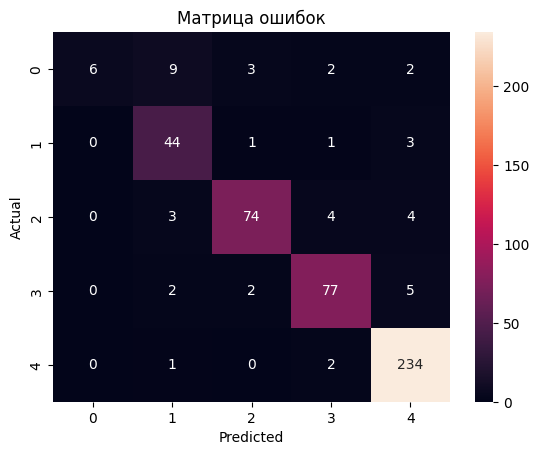

In [71]:
metrics(y_test, rf.predict(X_test))

Как видим, теперь для каждого класса у нас есть набор метрик, а также общие оценки.

И тепловая карта с матрицей ошибок выглядит лучше. Однако на ней заметен дисбаланс классов. А когда мы хотим оценить, где модель делает наибольшие ошибки, нам лучше занулить диагональ. Для этого в нашей функции `metrics` предусмотрен код.

              precision    recall  f1-score   support

         0.0       1.00      0.27      0.43        22
         1.0       0.75      0.90      0.81        49
         2.0       0.93      0.87      0.90        85
         3.0       0.90      0.90      0.90        86
         4.0       0.94      0.99      0.96       237

    accuracy                           0.91       479
   macro avg       0.90      0.78      0.80       479
weighted avg       0.91      0.91      0.90       479



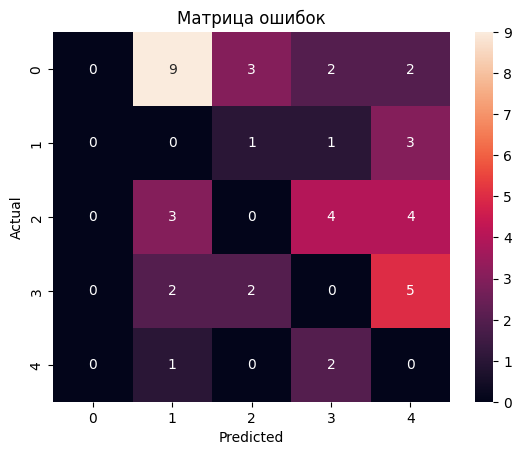

In [72]:
metrics(y_test, rf.predict(X_test), True)

Тут видно, где модель ошибается боьше всего.

В завершение предлагаю вам настроить и эту модель, подобрав лучшие гиперпараметры.

In [73]:
# Ваш код
...